For this assignment, you will use [NGSolve](https://docu.ngsolve.org/latest) to assemble the finite element problem. You can install all the requirements by running the cell below.

In [1]:
%pip install numpy==2.1.1 scipy==1.14.1 matplotlib==3.9.2 ngsolve==6.2.2501

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import numpy as np
import ngsolve as ngs
import matplotlib.pyplot as plt
from ngsolve.meshes import MakeQuadMesh, Make1DMesh
from schwarz_solvers import AlternatingSchwarzSolver, ParallelSchwarzSolver
import time

# 1D case

## Finite element setup

We start by initializing the mesh.

In [2]:
n = 10
xs = np.linspace(0, 1, n + 1)
mesh = Make1DMesh(n)

Then, we can define the function space from which the trial and test functions will be sampled. The object `fes` represents the finite element function space with null Dirichlet boundary conditions on the whole domain boundary. Given the function space, we get the trial and test functions `u` and `v`, respectively. Here, we consider piecewise linear functions (the hat functions you have seen on previous assignments).

In [3]:
fes = ngs.H1(mesh, dirichlet=".*")
u, v = fes.TnT()

With the trial and test functions well determined, we can proceed to define the weak form for our problem. From the lectures, the weak form of the Laplace equation can be stated as: given $f: \Omega \to \mathbb{R}$, find $u \in \mathcal{U}$ such that
$$
\forall v \in \mathcal{V}, \quad \int_{\Omega} \nabla v \cdot \nabla (\epsilon u) \, \text{d}x = \int_{\Omega} v f \, \text{d}x,
$$
The object `a` represents the bilinear form on the left-hand side of the weak form, and `f` the right-hand side. The call to the `Assemble` method performs the assembly of the stiffness matrix and the forcing vector. At this point, however, the Dirichlet boundary conditions *have not* yet been assigned. For the sequence, we consider $f = 1$ and $\epsilon = 1$.

In [4]:
a = ngs.BilinearForm(ngs.grad(u) * ngs.grad(v) * ngs.dx).Assemble()
f = ngs.LinearForm(v * ngs.dx).Assemble()

We can modify the forcing vector to set the Dirichlet boundary conditions. The method `FreeDofs` provides a boolean mask indicating which degrees of freedom are internal or not. If the degree of freedom is not free (i.e., it is on the boundary), then set the entry on the forcing vector to 0, the value of the Dirichlet boundary condition.

In [5]:
f.vec.FV().NumPy()[~fes.FreeDofs()] = 0

## Solver setup

We can now proceed to setting up our Schwarz solvers. First, we need to define the partition of the global domain into two **overlapping** subdomains. The 1D grid nodes are sorted in ascending order from left to right, as illustrated below.

```
x-----x-----x-----x-----x ... x-----x
0     1     2     3     4 ... n-2   n-1
```

Your task is to initialize the matrices `partition` and `boundaries`. These matrices indicate respectively the nodes that are inside and on the boundary of each overlapping subdomain. In other words, `partition[i, j] == 1` if node `j` is in the overlapping subdomain `i`. Similarly, `boundaries[i, j] == 1` if node `j` is on the boundary of the overlapping subdomain `i`, but not on the global boundary. An example of how these matrices look like can be seen below for $n = 4$ and one layer of overlapping elements.

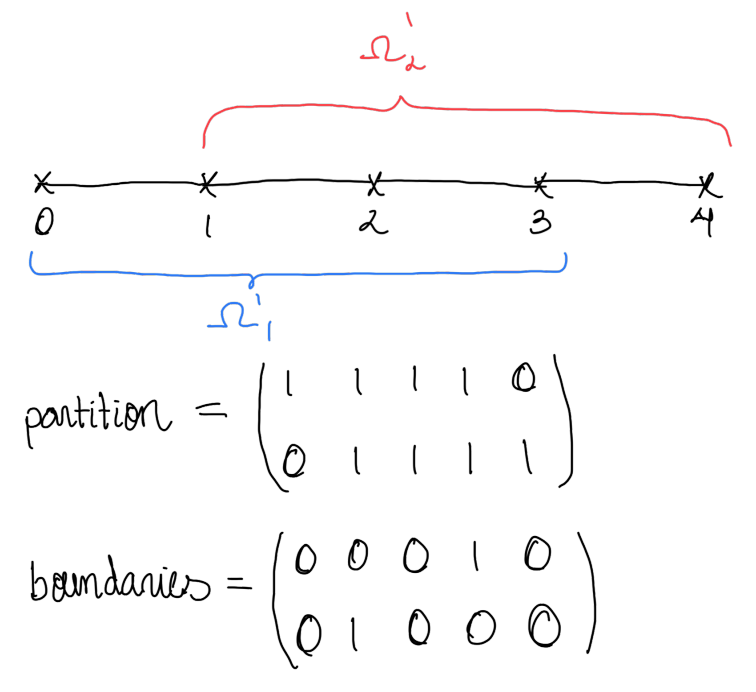

In [6]:
# Initialize the matrices partition and boundaries as described above.
partition = np.zeros((2, n + 1), dtype=int)
boundaries = np.zeros((2, n + 1), dtype=int)

for j in range(n+1):
    if j <= (n/2+1):
        partition[0,j] = 1

for j in range(n+1):
    if j >= (n/2-1):
        partition[1,j] = 1
    
boundaries[0,int(n/2 + 1)] = 1
boundaries[1, int(n/2 - 1)] = 1
        
print(partition)
print('\n')
print(boundaries)

[[1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1]]


[[0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]]


Now that we have the partition matrices well-defined, we can run the Schwarz iterations. We start with the alternating Schwarz iteration. The `AlternatingSchwarzSolver` implements this method. You can change the tolerance (`tol`), the maximum number of iterations (`maxiter`) and the overlapping partition (`partition` and `boundaries`) to see the effect in the accuracy and convergence of the method.

LinearSolver iteration 1, residual = 0.07453559924999298     
LinearSolver iteration 2, residual = 0.033126932999996854     
LinearSolver iteration 3, residual = 0.014723081333331783     
LinearSolver iteration 4, residual = 0.006543591703703052     
LinearSolver iteration 5, residual = 0.0029082629794235175     
LinearSolver iteration 6, residual = 0.0012925613241882219     
LinearSolver iteration 7, residual = 0.0005744716996391532     
LinearSolver iteration 8, residual = 0.0002553207553950964     
LinearSolver iteration 9, residual = 0.00011347589128671988     
LinearSolver iteration 10, residual = 5.0433729460743704e-05     
LinearSolver iteration 11, residual = 2.2414990871345792e-05     
LinearSolver iteration 12, residual = 9.962218165017748e-06     
LinearSolver iteration 13, residual = 4.4276525178146284e-06     
LinearSolver iteration 14, residual = 1.9678455634014507e-06     
LinearSolver iteration 15, residual = 8.745980281046361e-07     
LinearSolver iteration 16, residua

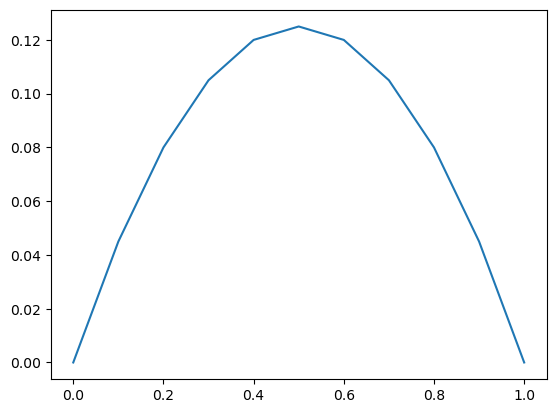

In [7]:
alt_schwarz_inv = AlternatingSchwarzSolver(
    a.mat,
    freedofs=fes.FreeDofs(),
    partition=partition,
    boundaries=boundaries,
    printrates=True,
    tol=1e-6,
    maxiter=100,
)

gfu = ngs.GridFunction(fes)
gfu.vec.data = alt_schwarz_inv * f.vec

fig, ax = plt.subplots()
ax.plot(xs, gfu.vec.FV().NumPy())
plt.show()

Similarly to the `AlternatingSchwarzSolver` class, the `ParallelSchwarzSolver` implements the parallel Schwarz iterations. As in the previous case, you can change the tolerance (`tol`), the maximum number of iterations (`maxiter`) and the overlapping partition (`partition` and `boundaries`) to see the effect in the accuracy and convergence of the method.

LinearSolver iteration 1, residual = 0.05656854249492383     
LinearSolver iteration 2, residual = 0.03771236166328254     
LinearSolver iteration 3, residual = 0.025141574442188373     
LinearSolver iteration 4, residual = 0.016761049628125517     
LinearSolver iteration 5, residual = 0.011174033085416967     
LinearSolver iteration 6, residual = 0.007449355390277994     
LinearSolver iteration 7, residual = 0.004966236926851973     
LinearSolver iteration 8, residual = 0.0033108246179012566     
LinearSolver iteration 9, residual = 0.002207216411934145     
LinearSolver iteration 10, residual = 0.0014714776079561259     
LinearSolver iteration 11, residual = 0.000980985071970731     
LinearSolver iteration 12, residual = 0.0006539900479804056     
LinearSolver iteration 13, residual = 0.00043599336532029655     
LinearSolver iteration 14, residual = 0.0002906622435468546     
LinearSolver iteration 15, residual = 0.0001937748290312004     
LinearSolver iteration 16, residual = 0.0001

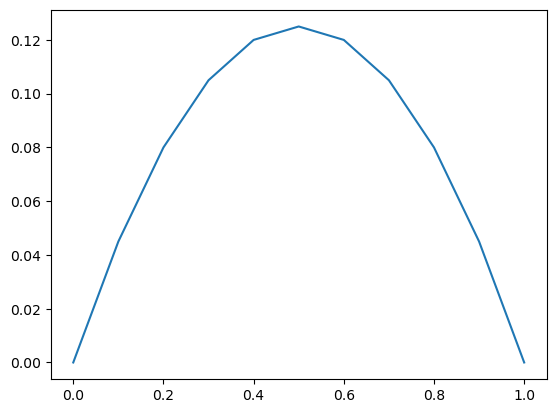

In [8]:
par_schwarz_inv = ParallelSchwarzSolver(
    a.mat,
    freedofs=fes.FreeDofs(),
    partition=partition,
    boundaries=boundaries,
    printrates=True,
    tol=1e-6,
    maxiter=100,
)

gfu = ngs.GridFunction(fes)
gfu.vec.data = par_schwarz_inv * f.vec

fig, ax = plt.subplots()
ax.plot(xs, gfu.vec.FV().NumPy())
plt.show()

# 2D case

## Finite element setup

As with the 1D example, we start by initializing the mesh. We will use a square grid with $n_x \times n_y$ cells.

In [132]:
nx, ny = 20, 10
xs, ys = np.meshgrid(np.linspace(0, 1, nx + 1), np.linspace(0, 1, ny + 1))
mesh = MakeQuadMesh(nx, ny, mapping=lambda x, y: (2 * x, y))

From here on, the assembly is performed in the same way as in the 1D case.

In [133]:
fes = ngs.H1(mesh, dirichlet=".*")
u, v = fes.TnT()

a = ngs.BilinearForm(ngs.grad(u) * ngs.grad(v) * ngs.dx).Assemble()

f = ngs.LinearForm(v * ngs.dx).Assemble()
f.vec.FV().NumPy()[~fes.FreeDofs()] = 0

## Solver setup

As in the 1D case, the matrices `partition` and `boundaries` still need to be initialized. For 2D meshes, the nodes are sorted from the left to the right, and from the bottom to the top. See the illustration below for an example where $n_x = n_y = 3$ and we have one layer of overlap. The partition matrices corresponding to the overlapping decomposition below would be:
```
partition = [[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
             [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]]
boundaries = [[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
              [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]
```

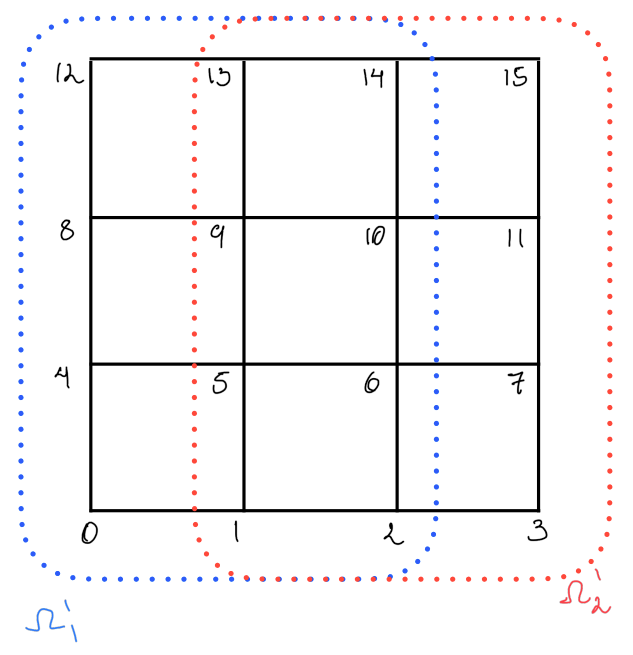

In [135]:
# Initialize the matrices partition and boundaries as described above.
partition = np.zeros((2, (nx + 1) * (ny + 1)), dtype=int)
boundaries = np.zeros((2, (nx + 1) * (ny + 1)), dtype=int)

size_1 = 12
overlap = 4
size_2 = nx-size_1+overlap

partition[0] = np.array((ny+1)*((size_1+1)*[1]+(nx-size_1)*[0]))
partition[1] = np.array((ny+1)*((nx-size_2)*[0]+(size_2+1)*[1]))

boundaries[0] = np.array((ny+1)*(size_1*[0] + [1] + (nx-size_1)*[0]))
boundaries[1] = np.array((ny+1)*((nx-size_2)*[0] + [1] + size_2*[0]))

Now that we have the partition matrices well-defined, we can run the Schwarz iterations. We start with the alternating Schwarz iteration. The `AlternatingSchwarzSolver` implements this method. You can change the tolerance (`tol`), the maximum number of iterations (`maxiter`) and the overlapping partition (`partition` and `boundaries`) to see the effect in the accuracy and convergence of the method.

LinearSolver iteration 1, residual = 0.30826547233096546     
LinearSolver iteration 2, residual = 0.024153222498506665     
LinearSolver iteration 3, residual = 0.0018938044150568093     
LinearSolver iteration 4, residual = 0.00014848930384659385     
LinearSolver iteration 5, residual = 1.1642740497104284e-05     
LinearSolver iteration 6, residual = 9.128833039359714e-07     
LinearSolver iteration 7, residual = 7.157729967169253e-08     
0.011492013931274414


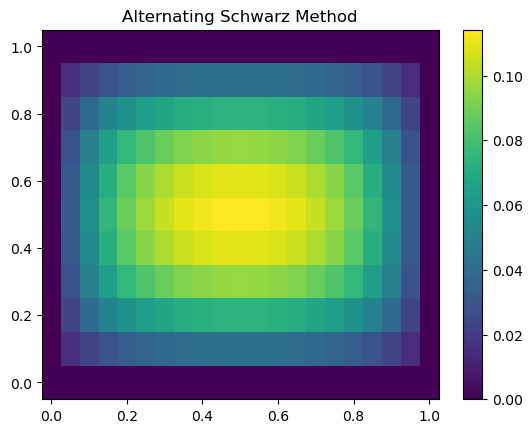

In [137]:
start = time.time()
alt_schwarz_inv = AlternatingSchwarzSolver(
    a.mat,
    freedofs=fes.FreeDofs(),
    partition=partition,
    boundaries=boundaries,
    printrates=True,
    tol=1e-6,
    maxiter=200,
)

gfu = ngs.GridFunction(fes)
gfu.vec.data = alt_schwarz_inv * f.vec

zs = gfu.vec.FV().NumPy().reshape(xs.shape)

print(time.time() - start)

fig, ax = plt.subplots()
pc = ax.pcolormesh(xs, ys, zs)
fig.colorbar(pc)
plt.title('Alternating Schwarz Method')
plt.savefig("Alternating")
plt.show()

Similarly to the `AlternatingSchwarzSolver` class, the `ParallelSchwarzSolver` implements the parallel Schwarz iterations. As in the previous case, you change the tolerance (`tol`), the maximum number of iterations (`maxiter`) and the overlapping partition (`partition` and `boundaries`) to see the effect in the accuracy and convergence of the method.

LinearSolver iteration 1, residual = 0.29269547878648394     
LinearSolver iteration 2, residual = 0.08183843242056396     
LinearSolver iteration 3, residual = 0.022915805095341992     
LinearSolver iteration 4, residual = 0.006416750233669407     
LinearSolver iteration 5, residual = 0.0017967810487966318     
LinearSolver iteration 6, residual = 0.000503124170329645     
LinearSolver iteration 7, residual = 0.00014088190152021268     
LinearSolver iteration 8, residual = 3.9448929998664395e-05     
LinearSolver iteration 9, residual = 1.1046259748320023e-05     
LinearSolver iteration 10, residual = 3.093109355144304e-06     
LinearSolver iteration 11, residual = 8.661144768914925e-07     
LinearSolver iteration 12, residual = 2.4252433418148695e-07     
0.008802413940429688


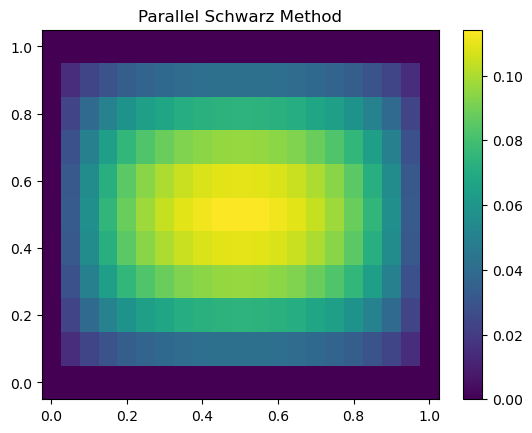

In [138]:
start = time.time()
par_schwarz_inv = ParallelSchwarzSolver(
    a.mat,
    freedofs=fes.FreeDofs(),
    partition=partition,
    boundaries=boundaries,
    printrates=True,
    tol=1e-6,
    maxiter=400,
)

gfu = ngs.GridFunction(fes)
gfu.vec.data = par_schwarz_inv * f.vec

zs = gfu.vec.FV().NumPy().reshape(xs.shape)

print(time.time() - start)

fig, ax = plt.subplots()
pc = ax.pcolormesh(xs, ys, zs)
fig.colorbar(pc)
plt.title('Parallel Schwarz Method')
plt.savefig("Parallel")
plt.show()

## Heterogeneous problem (bonus question)

Consider now a heterogeneous boundary value problem: find $u$ such that
$$
\begin{aligned}
    - \nabla \cdot \left( \epsilon(x) \nabla u \right) & = f \quad \text{in } \Omega,         \\
    u          & = 0 \quad \text{on } \partial\Omega, \\
\end{aligned}
$$
with $f = 1$ and $\epsilon: \mathbb{R}^2 \to \mathbb{R}^{+}$ a coefficient function defined as:
$$
\epsilon(x) = 
\begin{cases}
    10^k & \quad \text{in } \Omega^* = [3/4, 5/4] \times [2/5, 3/5], \\
    1 & \quad \text{elsewhere}.
\end{cases}
$$
This problem can be discretized using Q1 finite elements similarly to the homogeneous case seen before.

Let us start by defining the coefficient function using NGSolve.

In [139]:
nx, ny = 100, 50
xs, ys = np.meshgrid(np.linspace(0, 1, nx + 1), np.linspace(0, 1, ny + 1))
mesh = MakeQuadMesh(nx, ny, mapping=lambda x, y: (2 * x, y))

In [191]:
# Initialize the matrices partition and boundaries as described above.
partition = np.zeros((2, (nx + 1) * (ny + 1)), dtype=int)
boundaries = np.zeros((2, (nx + 1) * (ny + 1)), dtype=int)

size_1 = 60
overlap = 23
size_2 = nx-size_1+overlap

partition[0] = np.array((ny+1)*((size_1+1)*[1]+(nx-size_1)*[0]))
partition[1] = np.array((ny+1)*((nx-size_2)*[0]+(size_2+1)*[1]))

boundaries[0] = np.array((ny+1)*(size_1*[0] + [1] + (nx-size_1)*[0]))
boundaries[1] = np.array((ny+1)*((nx-size_2)*[0] + [1] + size_2*[0]))

In [192]:
# A piecewise constant function space.
material_fes = ngs.L2(mesh, order=0)

# The GridFunction class allows us to define the value of a function on node of the grid.
material_gf = ngs.GridFunction(material_fes)

# Find the elements inside the high coefficient region.
elem_vertices = np.array(
    [[mesh[vID].point for vID in el.vertices] for el in mesh.Elements()]
)
dx = np.abs(elem_vertices[:, :, 0] - 1.0)
dy = np.abs(elem_vertices[:, :, 1] - 0.5)

# Set the coefficient value.
k = 4   # You can change the value of k here to test different coefficient values.
material_gf.vec.FV().NumPy()[:] = 1
material_gf.vec.FV().NumPy()[np.all((dx <= 0.25) & (dy <= 0.1), axis=1)] = 10 ** k

# Initialize a CoefficientFunction object that can be plugged in the bilinear form.
coeff =  ngs.CoefficientFunction(material_gf).Compile()

Next, we modify our bilinear form to account the changing coefficient.

In [193]:
fes = ngs.H1(mesh, dirichlet=".*")
u, v = fes.TnT()

a = ngs.BilinearForm(coeff * ngs.grad(u) * ngs.grad(v) * ngs.dx).Assemble()

f = ngs.LinearForm(v * ngs.dx).Assemble()
f.vec.FV().NumPy()[~fes.FreeDofs()] = 0

Finally, we can solve the problem using the alternating and parallel Schwarz iterations.

LinearSolver iteration 1, residual = 1.0612341371131642     
LinearSolver iteration 2, residual = 0.053990405174445304     
LinearSolver iteration 3, residual = 0.0027536384955688478     
LinearSolver iteration 4, residual = 0.00014044295914547784     
LinearSolver iteration 5, residual = 7.162968357008453e-06     
LinearSolver iteration 6, residual = 3.6533068918189356e-07     


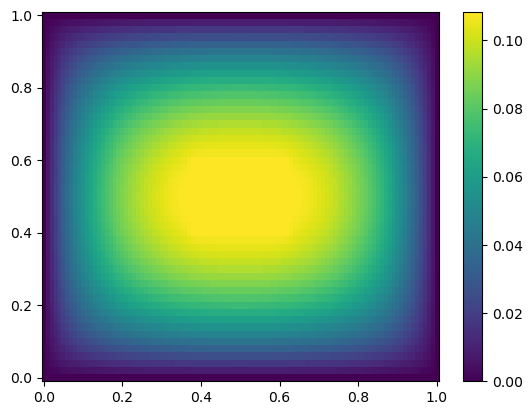

In [194]:
alt_schwarz_inv = AlternatingSchwarzSolver(
    a.mat,
    freedofs=fes.FreeDofs(),
    partition=partition,
    boundaries=boundaries,
    printrates=True,
    tol=1e-6,
    maxiter=200,
)

gfu = ngs.GridFunction(fes)
gfu.vec.data = alt_schwarz_inv * f.vec

zs = gfu.vec.FV().NumPy().reshape(xs.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(xs, ys, zs)
fig.colorbar(pc)
plt.show()

LinearSolver iteration 1, residual = 0.6104312923362588     
LinearSolver iteration 2, residual = 0.22645324767702976     
LinearSolver iteration 3, residual = 0.329027759074445     
LinearSolver iteration 4, residual = 0.15620353961936753     
LinearSolver iteration 5, residual = 0.2301978822778264     
LinearSolver iteration 6, residual = 0.10929954964035338     
LinearSolver iteration 7, residual = 0.1610775045916982     
LinearSolver iteration 8, residual = 0.07648072582183107     
LinearSolver iteration 9, residual = 0.11271157730984595     
LinearSolver iteration 10, residual = 0.053516245264826866     
LinearSolver iteration 11, residual = 0.07886824230252767     
LinearSolver iteration 12, residual = 0.03744719308711578     
LinearSolver iteration 13, residual = 0.05518687425336607     
LinearSolver iteration 14, residual = 0.026203113898661028     
LinearSolver iteration 15, residual = 0.03861619076244985     
LinearSolver iteration 16, residual = 0.01833523747399734     
Line

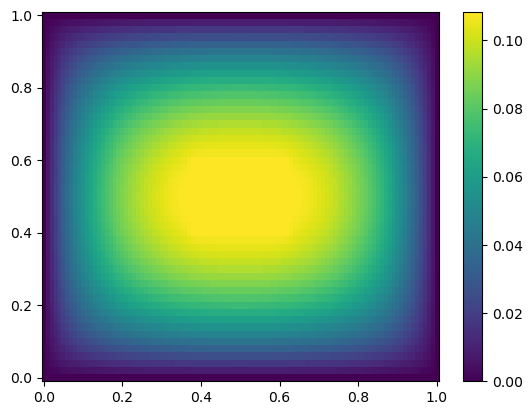

In [190]:
par_schwarz_inv = ParallelSchwarzSolver(
    a.mat,
    freedofs=fes.FreeDofs(),
    partition=partition,
    boundaries=boundaries,
    printrates=True,
    tol=1e-6,
    maxiter=400,
)

gfu = ngs.GridFunction(fes)
gfu.vec.data = par_schwarz_inv * f.vec

zs = gfu.vec.FV().NumPy().reshape(xs.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(xs, ys, zs)
fig.colorbar(pc)
plt.show()